# Проект по теме "Введение в машинное обучение"

# Рекомендация тарифов

**Цели и задачи:**
* Построить модель для задачи классификации, которая выберет подходящий для пользователей новый тариф сотовой связи.
* Оптимизировать модель по метрике accuracy (минимально допустимое значение **0.75**).
* Проверить **`accuracy`** на тестовой выборке.

**План выполнения работы:**
* 1.Изучение общей информации о данных
* 2. Построение моделей классификации
* 3.Исследование моделей
  * 3.1 Случайный лес
  * 3.2 Решающее дерево
  * 3.3 Логистическая регрессия
  * 3.4 Проверка на тестовой выборке
* (бонус) Проверьте модели на адекватность

**Описание данных:**

Каждый объект в наборе данных **users_behavior.csv** — это информация о поведении одного пользователя за месяц.

* **`сalls`** — количество звонков,
* **`minutes`** — суммарная длительность звонков в минутах,
* **`messages`** — количество sms-сообщений,
* **`mb_used`** — израсходованный интернет-трафик в Мб,
* **`is_ultra`** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# 1. Изучение общей информации о данных

In [1]:
# Импортируем все необдходимое
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import random
from scipy import stats as st
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier 
from tqdm import tqdm 
RANDOM = 25
import os
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

**Откроем и изучим файл**

In [2]:
pth1 = 'C:/Users/copok/Documents/Проекты/Яндекс практикум/6 Рекомендация тарифов/users_behavior.csv'
pth2 = '/datasets/users_behavior.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df= pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
display(df.head(10))
print('-'*50)
df.info()
print('-'*50)
print('Количество дублированных строк:', sum(df.duplicated()))
print()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
--------------------------------------------------
Количество дублированных строк: 0



* В таблице данных 3214 объектов. 
* Пропусков и Дубликатов нет.

**Изменим тип данных столбца `calls` и `messages` , на `int`, потому что неможет чтобы было дробное количество звонков и сообщений**

In [4]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


**Рассмотрим численные распределения данных в столбцах с помощью метода `describe()`.**

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


* По всем признакам медиана и среднее значение не сильно отличаются друг от друга. 
* Построим графики распределений признаков

In [6]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=df, x=data_label, ax=axes[1])
    plt.show()

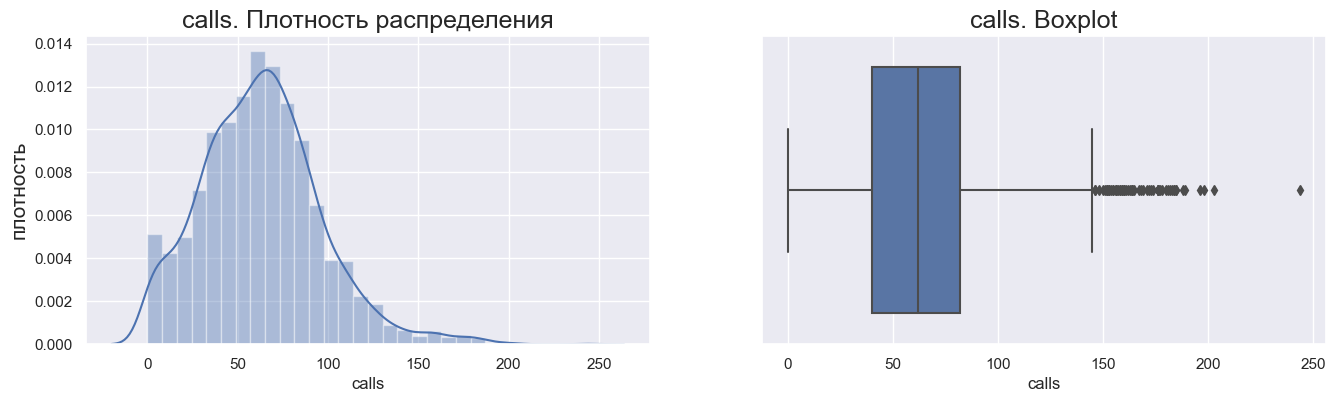

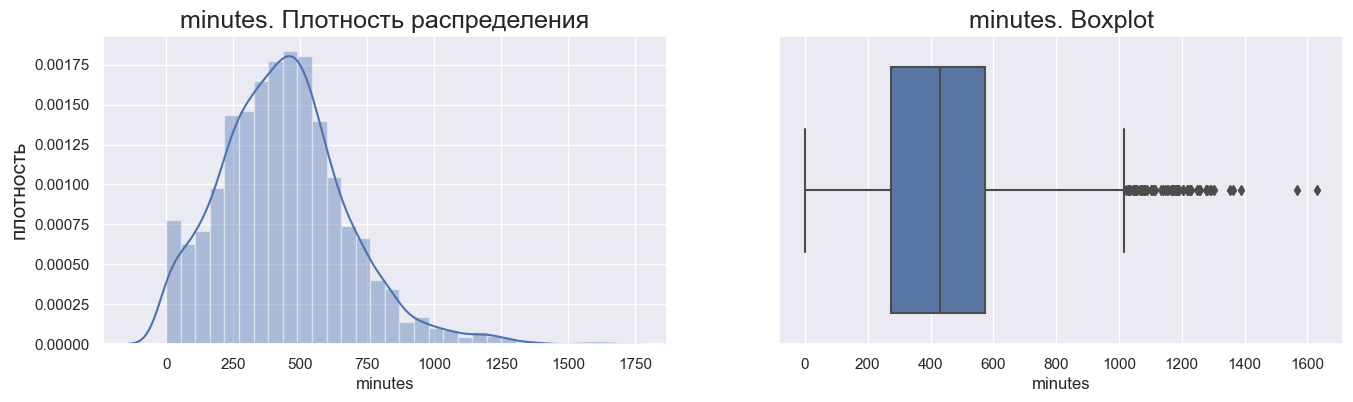

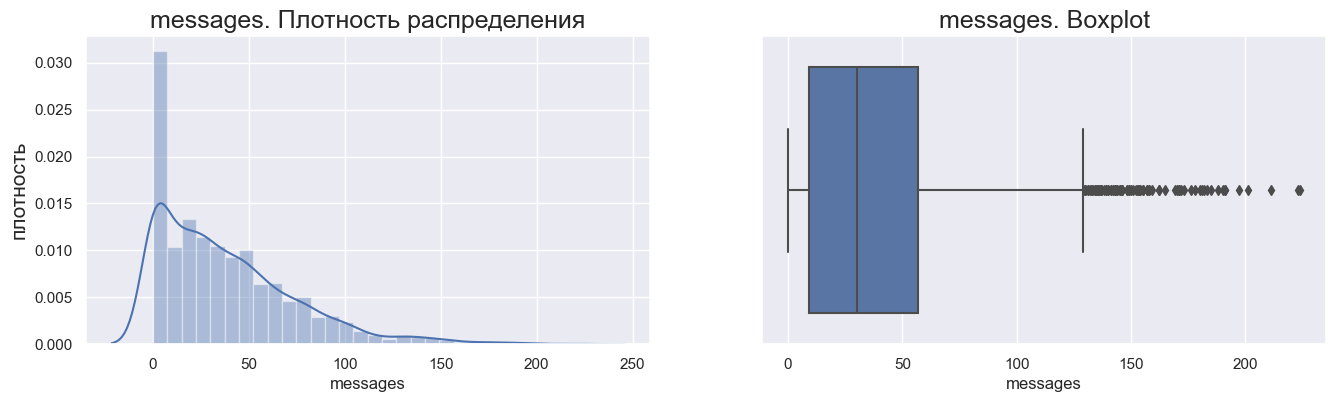

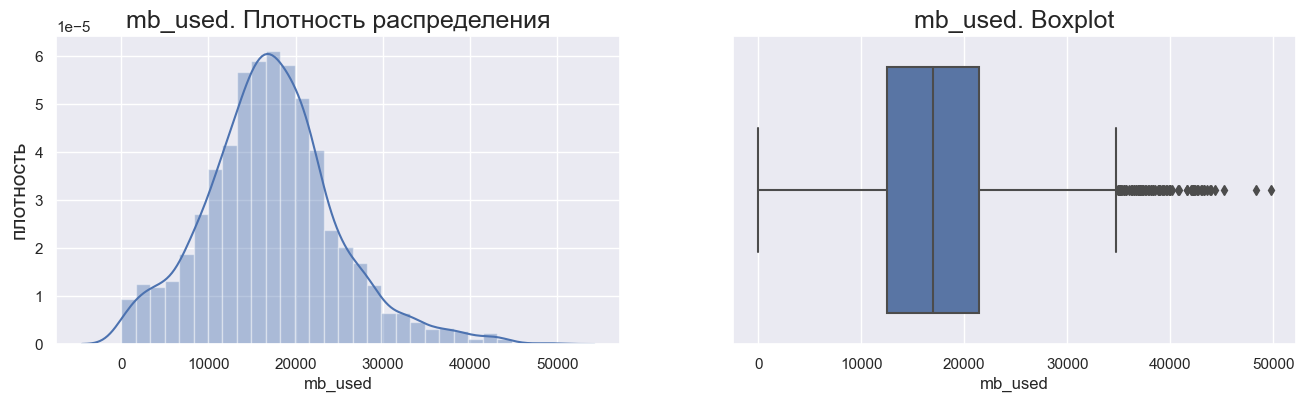

In [7]:
for column in df.drop('is_ultra', axis=1).columns:
    show_hists(df[column], column, num_bins=30)

* Из гистограммы столбца **`messages`** видно что есть значительная часть данных = 0. 
* Это вносит небольшой скос данных влево.

In [8]:
zero_messages = round(len(df.loc[df['messages'] == 0]) / len(df) * 100, 2)
print('Доля пользователей, не отправляющих сообщения: {} %'.format(zero_messages))

Доля пользователей, не отправляющих сообщения: 15.46 %


**Посмотрим матрицу Корреляции**

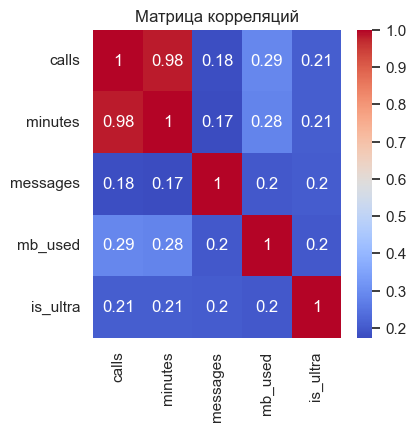

In [9]:
plt.figure(figsize=(4, 4))
plt.title('Матрица корреляций')

sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

plt.show()

* **Корреляция везде слабая за исключением между `звонками` и `минутами` (ну это естесственно).**

### Вывод

* Данные успешно загружены и проанализированы. Таблица данных содержит 3214 объектов, пропусков нет.
* Типы данных столбцов **`calls`** и **`messages`** заменены на целочисленный `int`.
* Сильного перекоса в распределениях данных не наблюдается.
* Корреляция везде слабая за исключением между `звонками` и `минутами` (**ну это естесственно**).

# 2. Построение моделей классификации

### Разобьем данные на выборки

**Поделим датафрейм на обучающую выборку и выборку, которую позже разделим на валидационную и тестовую.**

In [10]:
df_train, df_general = train_test_split(df, test_size=0.4, random_state=12345)
#Поделим df_general валидационную и тестовую выборку.
df_valid, df_test = train_test_split(df_general, test_size=0.5, random_state=12345)

**Проверим выборки**

In [11]:
df_train.shape, df_valid.shape, df_test.shape

((1928, 5), (643, 5), (643, 5))

In [12]:
1928+643+643

3214

In [13]:
643/3214, 643/3214, 1928/3214

(0.2000622277535781, 0.2000622277535781, 0.5998755444928439)

# 3.Исследование моделей

**Перед исследованием моделей разделим наши датафреймы на целевой признак который нужно предсказать и признаки, которые помогут нам его предсказать:**

In [14]:
#Разделим обучающий датафрейм
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

# Разделим валидационный датафрейм 
features_valid = df_valid.drop(['is_ultra'], axis=1)  
target_valid = df_valid['is_ultra']

### 3.1 Random Forest(Случайный лес)

* **Выделим гиперпараметры для настройки модели:**
  * **`n_estimators`** - количество деревьев
  * **`max_depth`** - максимальная глубина древа
  * **`min_samples_split`** - минимальное количество объектов в узле
  * **`min_samples_leaf`** - минимальное количество объектов в листе
  * **`criterion`** (**"gini"** или **"entropy"**) - функция измерения качества разделения
* Критерием проверки качества модели будет точность **`accuracy`**.

In [15]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую точность соответственно
best_params = []
best_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам
for n_estimators in tqdm(range(1,10)):
    for max_depth in range(2,10):
        for min_samples_split in range(2,10):
            for min_samples_leaf in range(1,8):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(features_train, target_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(features_valid)
                    # вычисление точности модели методом accuracy_score
                    accuracy = accuracy_score(target_valid, predictions)
                    # если текущее значение точности выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую точность
                    if accuracy > best_accuracy:
                        best_params = [n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_accuracy = accuracy
                        


100%|██████████| 9/9 [04:17<00:00, 28.59s/it]


In [16]:
print('''Наилучшая точность: {}
Парамтеры модели:
   n_estimators = {}
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {} '''.format(round(best_accuracy, 2),
                             best_params[0],
                             best_params[1],
                             best_params[2],
                             best_params[3],
                             best_params[4]
                            ))

Наилучшая точность: 0.81
Парамтеры модели:
   n_estimators = 3
   max_depth = 7
   min_samples_split = 6
   min_samples_leaf = 1
   criterion = entropy 


* **Данная модель удовлетворяет условиям технического задания. Посмотрим на результат с другими моделями.**

### 3.2 Decision Tree(Решающее дерево)

* Выделим гиперпараметры для настройки модели:
  * **`max_depth`** - максимальная глубина древа
  * **`min_samples_split`** - минимальное количество объектов в узле
  * **`min_samples_leaf`** - минимальное количество объектов в листе
  * **`criterion`** (**"gini"** или **"entropy"**) - функция измерения качества разделения
* Критерием проверки качества модели будет точность **`accuracy`**.

In [17]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую точность соответственно
best_params = []
best_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам
for max_depth in tqdm(range(2,10)):
    for min_samples_split in range(2,6):
        for min_samples_leaf in range(1,10):
            for criterion in ['gini', 'entropy']:
                # инициация модели с текущими гиперпараметрами
                model_dt_clf = DecisionTreeClassifier(random_state=123,
                                                      max_depth=max_depth,
                                                      min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      criterion=criterion)
                # обучение модели на тренировочной выборке
                model_dt_clf.fit(features_train, target_train)
                # поиск предсказаний модели на валидационной выбоке
                predictions = model_dt_clf.predict(features_valid)
                # вычисление точности модели методом accuracy_score
                accuracy = accuracy_score(target_valid, predictions)
                # если текущее значение точности выше предыдущего лучшего значения, 
                # сохраняем параметры модели и текущую точность
                if accuracy > best_accuracy:
                    best_params = [max_depth, min_samples_split, min_samples_leaf, criterion]
                    best_accuracy = accuracy

100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


In [18]:
# вывод наилучшей точности и параметров модели.
print('''Наилучшая точность: {}
Парамтеры модели:
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {} '''.format(round(best_accuracy, 2),
                             best_params[0],
                             best_params[1],
                             best_params[2],
                             best_params[3]
                            ))

Наилучшая точность: 0.79
Парамтеры модели:
   max_depth = 6
   min_samples_split = 2
   min_samples_leaf = 5
   criterion = entropy 


* **Данная модель тоже удовлетворяет условиям технического задания, однако её тоность уменьшилась на `2%` по сравнению со Случайным лесом**

### 3.3 LogisticRegression(Логистическая регрессия)

In [19]:
LR = LogisticRegression(random_state = RANDOM,max_iter= 1000,tol=1e-5,solver = 'lbfgs' )
LR.fit(features_train,target_train)
prediction_valid_LR = LR.predict(features_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, target_valid)
print(f"Наилучшая точность: {accuracy_LR}")

Наилучшая точность: 0.7107309486780715


* **Логистическая регрессия даёт более низкую точность, чем `решающее дерево` и `случайный лес`.**

### 3.4 Проверка модели на тестовой выборке

In [20]:
# Разделим тестовый датафрейм 
features_test = df_test.drop(['is_ultra'], axis=1)  
target_test = df_test['is_ultra']

* По критерию **`accuracy`** наилучшей точности удалось достичь с моделью **Случайного леса**
* Наилучшая точность: **0.81**
* Парамтеры модели: 
  * `n_estimators` = 3
  * `max_depth` = 7
  * `min_samples_split` = 6
  * `min_samples_leaf` = 1
  * `criterion` = **"entropy"** 

In [21]:
model_rf_clf = RandomForestClassifier(random_state=123,
                                      n_estimators=3,
                                      max_depth=7,
                                      min_samples_split=6,
                                      min_samples_leaf=1,
                                      criterion='entropy')
model_rf_clf.fit(features_train, target_train)
predictions = model_rf_clf.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Точность модели на тестовой выборке: {}'.format(round(accuracy, 2)))

Точность модели на тестовой выборке: 0.8


#### Вывод

* Были проанализированы различные классификационные модели: **Случайный лес**, **Решающее дерево**, **Логистическая регрессия**.
* Каждая модель была обучена для различных сочетаний гиперпараметров; выведены наилучшие варианты для каждой модели.
* Наилучшая точность (**accuracy**) была достигнута для модели **Случайного леса**:
  * **`Accuracy`** на валидационной выборке: **0.81**
  * **`Accuracy`** на тестовой выборке: **0.8**

## (бонус) Проверьте модели на адекватность

Для проверки адекватности модели мы можем воспользоваться **`DummyClassifier`**, который всегда предсказывает мажоритарный класс (в данном случае класс «0» - smart), чтобы проиллюстрировать, насколько малоинформативной может быть правильность:

In [22]:
dс = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
pred_most_frequent = dс.predict(features_test)
print("Спрогнозированные метки: {}".format(np.unique(pred_most_frequent)))
print("Правильность на тестовом наборе: {:.2f}".format(dс.score(features_test, target_test)))

Спрогнозированные метки: [0]
Правильность на тестовом наборе: 0.68


* **Дамми-классификатор**, который генерирует случайные прогнозы, имеет намного худшее качество (с точки зрения точности). 
* Однако даже случайный классификатор дает **68%-ную** правильность.

* Проблема здесь заключается в том, что для несбалансированных наборов данных правильность не является адекватной метрикой, позволяющей количественно оценить прогностическую способность модели.